In [3]:
# Start current environment
using Pkg
Pkg.activate(".")
Pkg.instantiate()
# Load and precompile the used packages
using CSV, DataFrames, StatsPlots, Statistics, Turing
gr(size=(800,400))

  Activating environment at `c:\Users\Ub\Documents\Code\BayesianMethodsForHackers\BayesianMethodsTuring\Project.toml`


Plots.GRBackend()

# Load and visualize the data
CSV supports Tables.jl and can be loaded into a `DataFrame`

`DataFrame` can be converted to another data structure

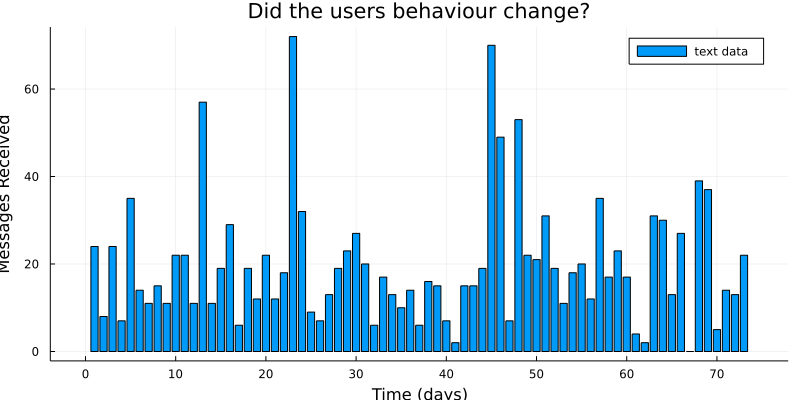

In [4]:
txt_df = CSV.File("../data/chapter1/txtdata.csv") |> DataFrame
txt_data = Matrix(txt_df)
bar(txt_data, title="Did the users behaviour change?", xlabel="Time (days)", xticks=0:10:80, ylabel="Messages Received", label="text data")

# Model
- The number of text messages per day is discrete and thus assumed to be Poisson distributed
- It is assumed that the number of received text messages changes once at day $\tau$
- Thus, two different parameters $\lambda_i$ are required for two differen Poisson distributions
- Exponential distribution has expected value as parameter $e^{1/\theta}$ instead of $e^{\lambda}$

In [5]:
@model function user_behaviour(data)
    θ = mean(data)
    λ_1 ~ Exponential(θ)
    λ_2 ~ Exponential(θ)
    τ ~ DiscreteUniform(length(data))
    for i in eachindex(data)
        if i < τ
            data[i] ~ Poisson(λ_1)
        else
            data[i] ~ Poisson(λ_2)
        end
    end
end;

Sampling via Metropolis Hastings. Other gradient based samplers have numerical issues for this example. Possible explanations:
- Discrete Variables do not work well
- Stochastic Control Flows do not work well

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


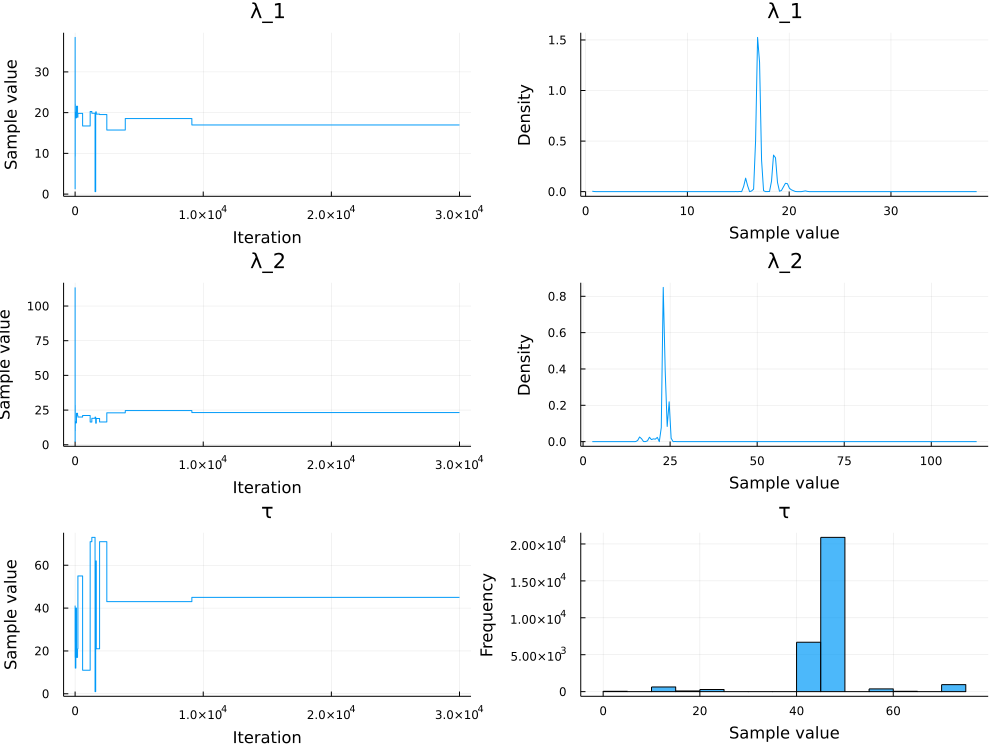

In [6]:
chain = sample(user_behaviour(txt_data), MH(), 30_000)
plot(chain)

# Samples from the Posterior
Visualize the expected texts per day. For each day:
- Determine the indices for which `λ_1` and `λ_2` is used for all samples
- Calculate the expected text value by marginalizing `τ`

In [7]:
using LinearAlgebra
expected_texts = zeros(length(txt_data))
for day = eachindex(txt_data)
    ix = [day < τ for τ in chain[:τ]]
    expected_texts[day] = sum(ix ⋅ chain[:λ_1]) + sum(.!ix ⋅ chain[:λ_2])
    expected_texts[day] = expected_texts[day] / length(ix)
end;

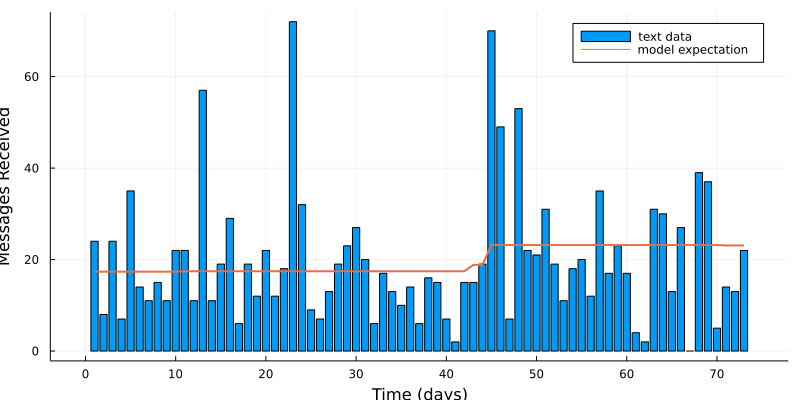

In [8]:
bar(txt_data, xlabel="Time (days)", xticks=0:10:80, ylabel="Messages Received", label="text data")
plot!(expected_texts, label="model expectation", linewidth=2)

# Thoughts
- Idiomatic usage without a lot boilerplate
- Good integration into other Julia libraries like StatsPlots and DataFrames
- Seems to focus on Advanced HMC, not clear how to specify complex models for computer vision or composing different models